<a href="https://colab.research.google.com/github/JonathanRosasV/Markowitz-Peru/blob/main/Markowitz_Peru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
# Carga de paquetes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import scipy.optimize as sco

# JIC
plt.style.use('fivethirtyeight')
np.random.seed(777)

# Definir fechas
start = pd.to_datetime('2022-01-01')
end = pd.to_datetime('2024-10-03')

# Descargar datos usando yfinance
stock_1 = 'FERREYC1.LM'  # Acción de Ferreyros
stock_2 = 'ALICORC1.LM'  # Acción de Alicorp
stock_3 = 'CPACASC1.LM'  # Acción de Alicorp
stock_4 = 'MINSURI1.LM'  # Acción de Alicorp

# Descargar datos directamente usando yfinance
acciones = [stock_1, stock_2, stock_3, stock_4]
portafolio = yf.download(acciones, start=start, end=end)['Adj Close']

# Mostrar los primeros datos para verificar
print(portafolio.head())

[*********************100%***********************]  4 of 4 completed

Ticker                     ALICORC1.LM  CPACASC1.LM  FERREYC1.LM  MINSURI1.LM
Date                                                                         
2022-01-03 00:00:00+00:00     5.533942     3.966798     1.572178     3.814862
2022-01-04 00:00:00+00:00     5.671146     3.991134     1.637383     4.220899
2022-01-05 00:00:00+00:00     5.808352     4.007359     1.637383     4.249228
2022-01-06 00:00:00+00:00     5.899822     4.056031     1.651874     4.164243
2022-01-07 00:00:00+00:00     6.064468     4.072255     1.644628     4.249228


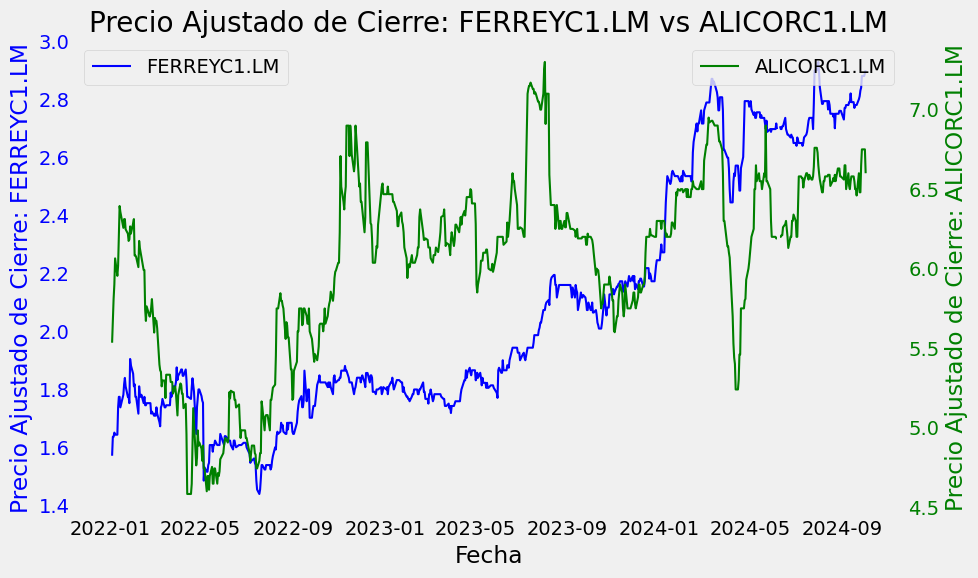

In [18]:
# Grafico N° 01
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(portafolio.index, portafolio[stock_1], color='blue', label=stock_1, linewidth=1.5)
ax1.set_xlabel('Fecha')
ax1.set_ylabel(f'Precio Ajustado de Cierre: {stock_1}', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(False)

ax2 = ax1.twinx()
ax2.plot(portafolio.index, portafolio[stock_2], color='green', label=stock_2, linewidth=1.5)
ax2.set_ylabel(f'Precio Ajustado de Cierre: {stock_2}', color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.grid(False)
plt.title(f'Precio Ajustado de Cierre: {stock_1} vs {stock_2}')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
fig.tight_layout()
plt.show()



In [19]:
# Calcular los retornos diarios
retornos_diarios = portafolio.pct_change().dropna()
print(retornos_diarios.head())
#retornos_diarios.plot()

Ticker                     ALICORC1.LM  CPACASC1.LM  FERREYC1.LM  MINSURI1.LM
Date                                                                         
2022-01-04 00:00:00+00:00     0.024793     0.006135     0.041474     0.106436
2022-01-05 00:00:00+00:00     0.024194     0.004065     0.000000     0.006711
2022-01-06 00:00:00+00:00     0.015748     0.012146     0.008850    -0.020000
2022-01-07 00:00:00+00:00     0.027907     0.004000    -0.004386     0.020408
2022-01-10 00:00:00+00:00    -0.018099    -0.003984     0.000000     0.033333


<ipython-input-19-92adf6a1f9cf>:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  retornos_diarios = portafolio.pct_change().dropna()


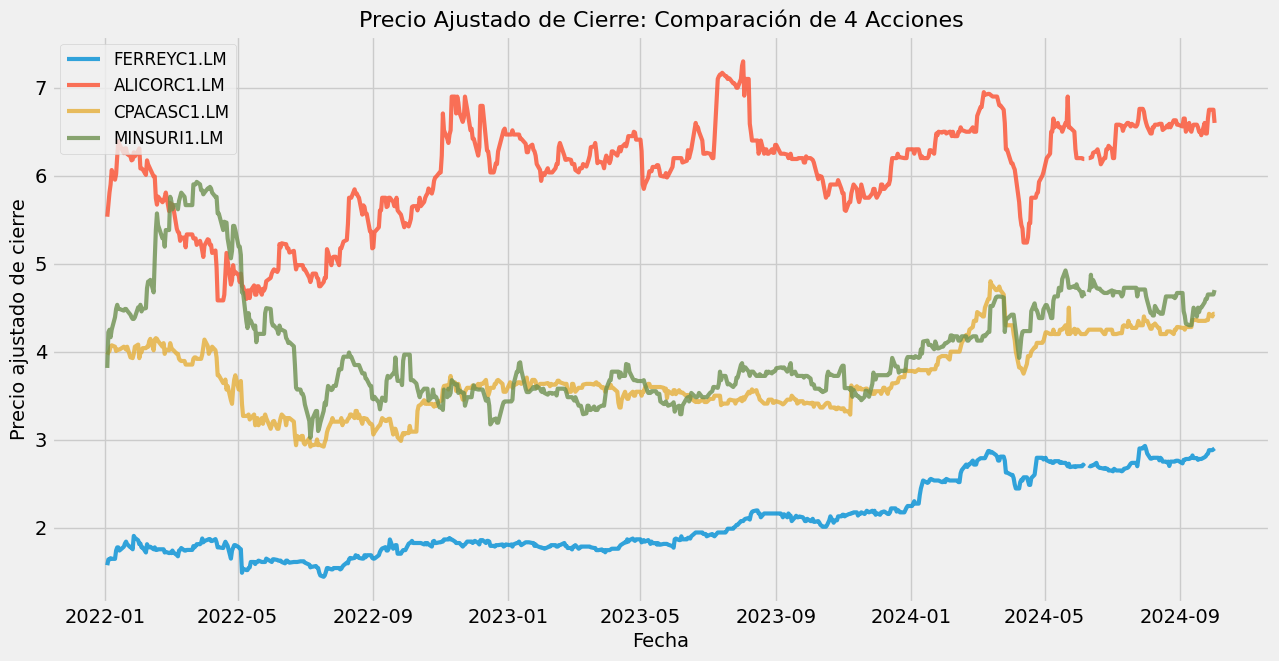

In [20]:
# Grafico N° 02

plt.figure(figsize=(14, 7))
for stock in acciones:
    plt.plot(portafolio.index, portafolio[stock], lw=3, alpha=0.8, label=stock)

plt.legend(loc='upper left', fontsize=12)
plt.ylabel('Precio ajustado de cierre', fontsize=14)
plt.xlabel('Fecha', fontsize=14)
plt.title(f'Precio Ajustado de Cierre: Comparación de 4 Acciones', fontsize=16)
plt.show()

<ipython-input-21-8dd5ad395516>:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = portafolio.pct_change().dropna()


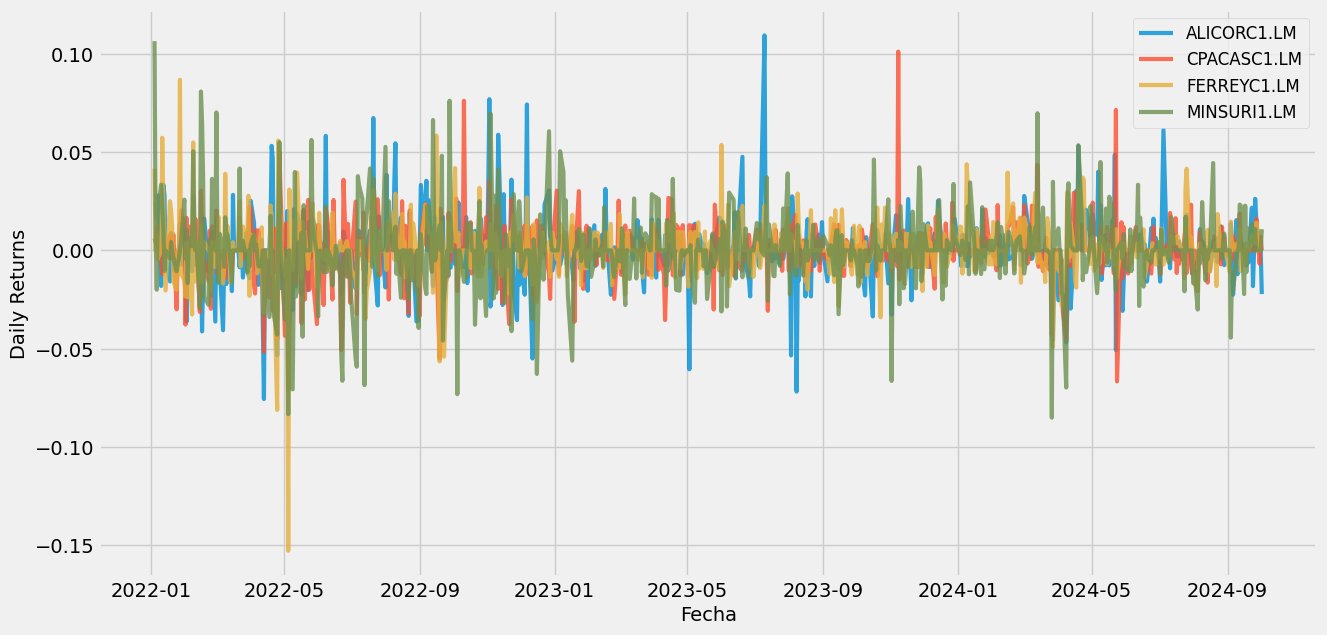

In [21]:
# Calcular los retornos diarios de las acciones en el DataFrame portafolio
returns = portafolio.pct_change().dropna()

plt.figure(figsize=(14, 7))

for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8, label=c)

plt.legend(loc='upper right', fontsize=12)
plt.ylabel('Daily Returns', fontsize=14)
plt.xlabel('Fecha', fontsize=14)
plt.show()

In [22]:
# Función para calcular el rendimiento anualizado y la volatilidad anualizada del portafolio
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights) * 252  # Rendimiento anualizado
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)  # Volatilidad anualizada
    return std, returns

# Función para generar portafolios aleatorios
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3, num_portfolios))  # Array para almacenar resultados: std, return, Sharpe ratio
    weights_record = []  # Para registrar los pesos generados

    for i in range(num_portfolios):
        # Generar pesos aleatorios
        weights = np.random.random(4)
        weights /= np.sum(weights)  # Asegurarse de que los pesos sumen 1

        # Guardar los pesos
        weights_record.append(weights)

        # Calcular rendimiento y volatilidad del portafolio
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)

        # Guardar los resultados
        results[0, i] = portfolio_std_dev  # Volatilidad
        results[1, i] = portfolio_return  # Rendimiento
        results[2, i] = (portfolio_return - risk_free_rate) / portfolio_std_dev  # Ratio de Sharpe

    return results, weights_record


In [25]:
# Cálculo de los retornos diarios, media de retornos y matriz de covarianza
returns = portafolio.pct_change().dropna()
mean_returns = returns.mean()
cov_matrix = returns.cov()

# Definir el número de portafolios y la tasa libre de riesgo
num_portfolios = 10000
risk_free_rate = 0.03


<ipython-input-25-8bde9cbeebfb>:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = portafolio.pct_change().dropna()


--------------------------------------------------------------------------------
Asignación del Portafolio con Máximo Ratio de Sharpe

Retornos Anualizados: 0.24
Volatilidad Anualizada: 0.22

 Ticker      ALICORC1.LM  CPACASC1.LM  FERREYC1.LM  MINSURI1.LM
allocation          2.4         1.09        88.77         7.75
--------------------------------------------------------------------------------
Asignación del Portafolio con Mínima Volatilidad

Retornos Anualizados: 0.13
Volatilidad Anualizada: 0.16

 Ticker      ALICORC1.LM  CPACASC1.LM  FERREYC1.LM  MINSURI1.LM
allocation        24.79        34.67        26.55        13.99


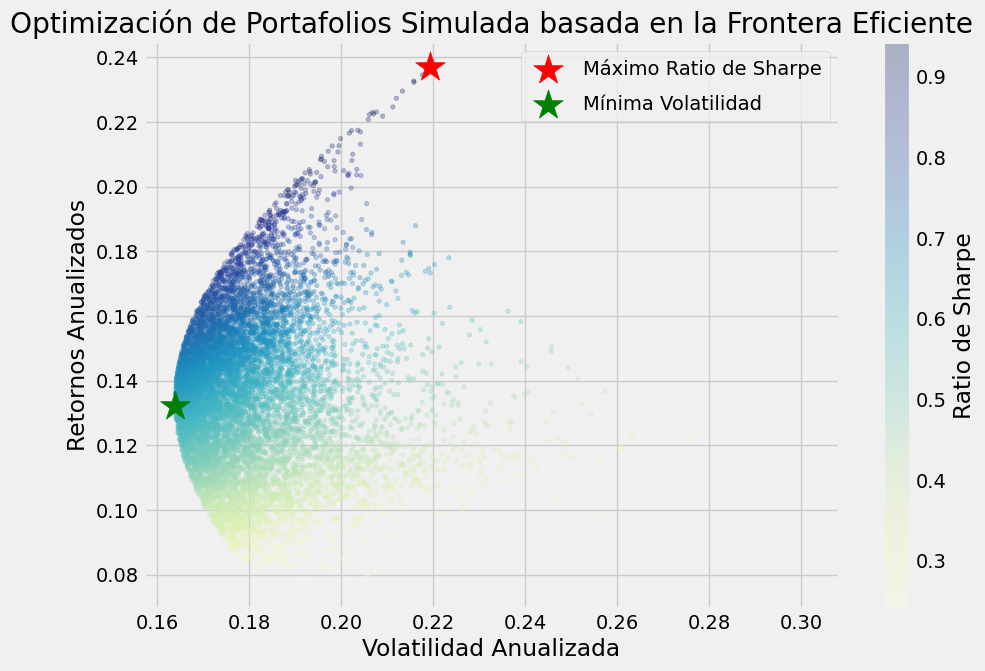

In [28]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    # Generar portafolios aleatorios
    results, weights = random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate)

    # Encontrar el portafolio con el ratio de Sharpe máximo
    max_sharpe_idx = np.argmax(results[2])  # Índice del Sharpe Ratio máximo
    sdp, rp = results[0, max_sharpe_idx], results[1, max_sharpe_idx]  # Volatilidad y retorno del portafolio
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx], index=portafolio.columns, columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100, 2) for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    # Encontrar el portafolio con la mínima volatilidad
    min_vol_idx = np.argmin(results[0])  # Índice de mínima volatilidad
    sdp_min, rp_min = results[0, min_vol_idx], results[1, min_vol_idx]  # Volatilidad y retorno del portafolio
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx], index=portafolio.columns, columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100, 2) for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T

    # Mostrar las asignaciones y resultados
    print("-" * 80)
    print("Asignación del Portafolio con Máximo Ratio de Sharpe\n")
    print("Retornos Anualizados:", round(rp, 2))
    print("Volatilidad Anualizada:", round(sdp, 2))
    print("\n", max_sharpe_allocation)
    print("-" * 80)
    print("Asignación del Portafolio con Mínima Volatilidad\n")
    print("Retornos Anualizados:", round(rp_min, 2))
    print("Volatilidad Anualizada:", round(sdp_min, 2))
    print("\n", min_vol_allocation)

    # Graficar la frontera eficiente
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0, :], results[1, :], c=results[2, :], cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar(label='Ratio de Sharpe')

    # Resaltar los portafolios óptimos
    plt.scatter(sdp, rp, marker='*', color='r', s=500, label='Máximo Ratio de Sharpe')
    plt.scatter(sdp_min, rp_min, marker='*', color='g', s=500, label='Mínima Volatilidad')

    # Etiquetas y título
    plt.title('Optimización de Portafolios Simulada basada en la Frontera Eficiente')
    plt.xlabel('Volatilidad Anualizada')
    plt.ylabel('Retornos Anualizados')
    plt.legend(labelspacing=0.8)
    plt.show()

# Llamada a la función con los parámetros calculados
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)


In [29]:
# Función para calcular el Sharpe ratio negativo (para maximización)
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    # Calcular la varianza (volatilidad) y el retorno del portafolio
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    # Retornar el Sharpe ratio negativo
    return -(p_ret - risk_free_rate) / p_var

# Función para maximizar el Sharpe ratio
def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)  # Número de activos
    args = (mean_returns, cov_matrix, risk_free_rate)  # Argumentos para la función de optimización
    # Restricción: la suma de los pesos debe ser 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    # Límite: los pesos deben estar entre 0 y 1
    bound = (0.0, 1.0)
    bounds = tuple(bound for asset in range(num_assets))  # Definir límites para cada activo

    # Ejecutar la optimización minimizando el Sharpe ratio negativo
    result = sco.minimize(neg_sharpe_ratio, num_assets * [1./num_assets,], args=args,
                          method='SLSQP', bounds=bounds, constraints=constraints)

    return result


In [30]:
# Función para calcular la volatilidad del portafolio
def portfolio_volatility(weights, mean_returns, cov_matrix):
    # Devuelve solo la volatilidad (la primera salida de portfolio_annualised_performance)
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

# Función para minimizar la volatilidad (varianza) del portafolio
def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)  # Número de activos
    args = (mean_returns, cov_matrix)  # Argumentos para la función de optimización
    # Restricción: la suma de los pesos debe ser 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    # Límite: los pesos deben estar entre 0 y 1
    bound = (0.0, 1.0)
    bounds = tuple(bound for asset in range(num_assets))  # Definir límites para cada activo

    # Ejecutar la optimización minimizando la volatilidad del portafolio
    result = sco.minimize(portfolio_volatility, num_assets * [1./num_assets,], args=args,
                          method='SLSQP', bounds=bounds, constraints=constraints)

    return result


In [31]:
# Función para encontrar el portafolio eficiente con un retorno objetivo
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)  # Número de activos
    args = (mean_returns, cov_matrix)

    # Función interna para calcular el retorno del portafolio
    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]  # Solo el retorno

    # Restricciones: 1) El retorno del portafolio debe ser igual al objetivo (target)
    # 2) La suma de los pesos debe ser igual a 1
    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

    # Límite de los pesos entre 0 y 1
    bounds = tuple((0, 1) for asset in range(num_assets))

    # Minimizar la volatilidad del portafolio dado el retorno objetivo
    result = sco.minimize(portfolio_volatility, num_assets * [1. / num_assets,], args=args,
                          method='SLSQP', bounds=bounds, constraints=constraints)
    return result

# Función para calcular la frontera eficiente (portafolios con diferentes niveles de retorno objetivo)
def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []  # Lista para almacenar los portafolios eficientes
    for ret in returns_range:  # Iterar sobre el rango de retornos objetivo
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients


In [35]:
def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    # Generar portafolios aleatorios
    results, _ = random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate)

    # Maximizar el Sharpe Ratio
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)  # Volatilidad y rendimiento
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x, index=portafolio.columns, columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i * 100, 2) for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    # Minimizar la volatilidad
    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x, index=portafolio.columns, columns=['allocation'])
    min_vol_allocation.allocation = [round(i * 100, 2) for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T

    # Calcular retornos anualizados
    an_rt = mean_returns * 252  # 252 días de trading al año

    # Imprimir la asignación de los portafolios óptimos
    print("-" * 80)
    print("Asignación del Portafolio con Máximo Ratio de Sharpe\n")
    print("Retorno Anualizado:", round(rp, 2))
    print("Volatilidad Anualizada:", round(sdp, 2))
    print("\n", max_sharpe_allocation)
    print("-" * 80)
    print("Asignación del Portafolio con Mínima Volatilidad\n")
    print("Retorno Anualizado:", round(rp_min, 2))
    print("Volatilidad Anualizada:", round(sdp_min, 2))
    print("\n", min_vol_allocation)

    # Graficar los portafolios aleatorios
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0, :], results[1, :], c=results[2, :], cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar(label='Ratio de Sharpe')

    # Marcar el portafolio de máximo Sharpe Ratio
    plt.scatter(sdp, rp, marker='*', color='r', s=500, label='Máximo Ratio de Sharpe')

    # Marcar el portafolio de mínima volatilidad
    plt.scatter(sdp_min, rp_min, marker='*', color='g', s=500, label='Mínima Volatilidad')

    # Generar la frontera eficiente
    target = np.linspace(rp_min, an_rt.max(), 50)  # Rango de retornos
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='Frontera Eficiente')

    # Etiquetas y título
    plt.title('Optimización de Portafolios Calculada basada en la Frontera Eficiente')
    plt.xlabel('Volatilidad Anualizada')
    plt.ylabel('Retornos Anualizados')
    plt.legend(labelspacing=0.8)
    plt.show()


--------------------------------------------------------------------------------
Asignación del Portafolio con Máximo Ratio de Sharpe

Retorno Anualizado: 0.25
Volatilidad Anualizada: 0.23

 Ticker      ALICORC1.LM  CPACASC1.LM  FERREYC1.LM  MINSURI1.LM
allocation          0.0          0.0        94.41         5.59
--------------------------------------------------------------------------------
Asignación del Portafolio con Mínima Volatilidad

Retorno Anualizado: 0.13
Volatilidad Anualizada: 0.16

 Ticker      ALICORC1.LM  CPACASC1.LM  FERREYC1.LM  MINSURI1.LM
allocation         24.5        34.28        27.71        13.51


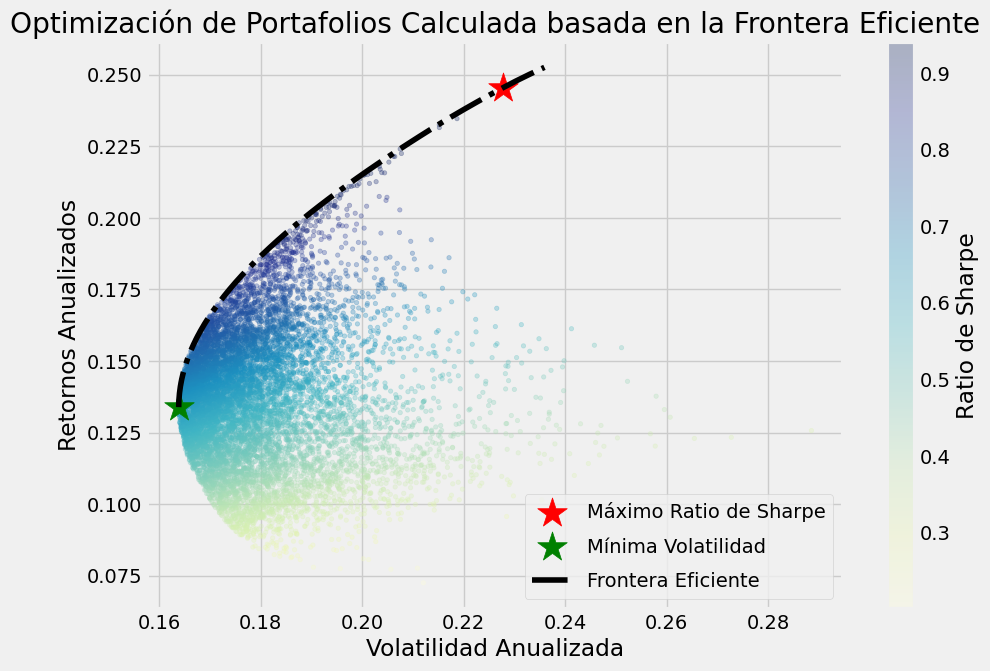

In [36]:
display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)


In [37]:
def display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate):
    # Maximizar el Sharpe Ratio
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x, index=portafolio.columns, columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i * 100, 2) for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    # Minimizar la volatilidad
    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x, index=portafolio.columns, columns=['allocation'])
    min_vol_allocation.allocation = [round(i * 100, 2) for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T

    # Calcular retornos y volatilidades anualizados de las acciones individuales
    an_vol = np.std(returns) * np.sqrt(252)  # Volatilidad anualizada
    an_rt = mean_returns * 252  # Retornos anualizados

    # Imprimir asignaciones y resultados de los portafolios
    print("-" * 80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp, 2))
    print("Annualised Volatility:", round(sdp, 2))
    print("\n", max_sharpe_allocation)
    print("-" * 80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min, 2))
    print("Annualised Volatility:", round(sdp_min, 2))
    print("\n", min_vol_allocation)
    print("-" * 80)
    print("Individual Stock Returns and Volatility\n")
    for i, txt in enumerate(portafolio.columns):
        print(txt, ":", "annualised return", round(an_rt[i], 2), ", annualised volatility:", round(an_vol[i], 2))
    print("-" * 80)

    # Graficar retornos y volatilidades de las acciones individuales
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(an_vol, an_rt, marker='o', s=200)

    # Anotar los nombres de las acciones individuales en el gráfico
    for i, txt in enumerate(portafolio.columns):
        ax.annotate(txt, (an_vol[i], an_rt[i]), xytext=(10, 0), textcoords='offset points')

    # Marcar el portafolio de máximo Sharpe Ratio
    ax.scatter(sdp, rp, marker='*', color='r', s=500, label='Maximum Sharpe ratio')

    # Marcar el portafolio de mínima volatilidad
    ax.scatter(sdp_min, rp_min, marker='*', color='g', s=500, label='Minimum volatility')

    # Generar la frontera eficiente
    target = np.linspace(rp_min, an_rt.max(), 50)  # Rango de retornos
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='Efficient Frontier')

    # Etiquetas y título del gráfico
    ax.set_title('Portfolio Optimization with Individual Stocks')
    ax.set_xlabel('Annualised Volatility')
    ax.set_ylabel('Annualised Returns')
    ax.legend(labelspacing=0.8)
    plt.show()


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
<ipython-input-37-aefdec762241>:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(txt, ":", "annualised return", round(an_rt[i], 2), ", annualised volatility:", round(an_vol[i], 2))
<ipython-input-37-aefdec762241>:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.an

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.25
Annualised Volatility: 0.23

 Ticker      ALICORC1.LM  CPACASC1.LM  FERREYC1.LM  MINSURI1.LM
allocation          0.0          0.0        94.41         5.59
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.13
Annualised Volatility: 0.16

 Ticker      ALICORC1.LM  CPACASC1.LM  FERREYC1.LM  MINSURI1.LM
allocation         24.5        34.28        27.71        13.51
--------------------------------------------------------------------------------
Individual Stock Returns and Volatility

ALICORC1.LM : annualised return 0.1 , annualised volatility: 0.26
CPACASC1.LM : annualised return 0.07 , annualised volatility: 0.23
FERREYC1.LM : annualised return 0.25 , annualised volatility: 0.24
MINSURI1.LM : annualised return 0.12 , annualised volatility: 0.31
-----

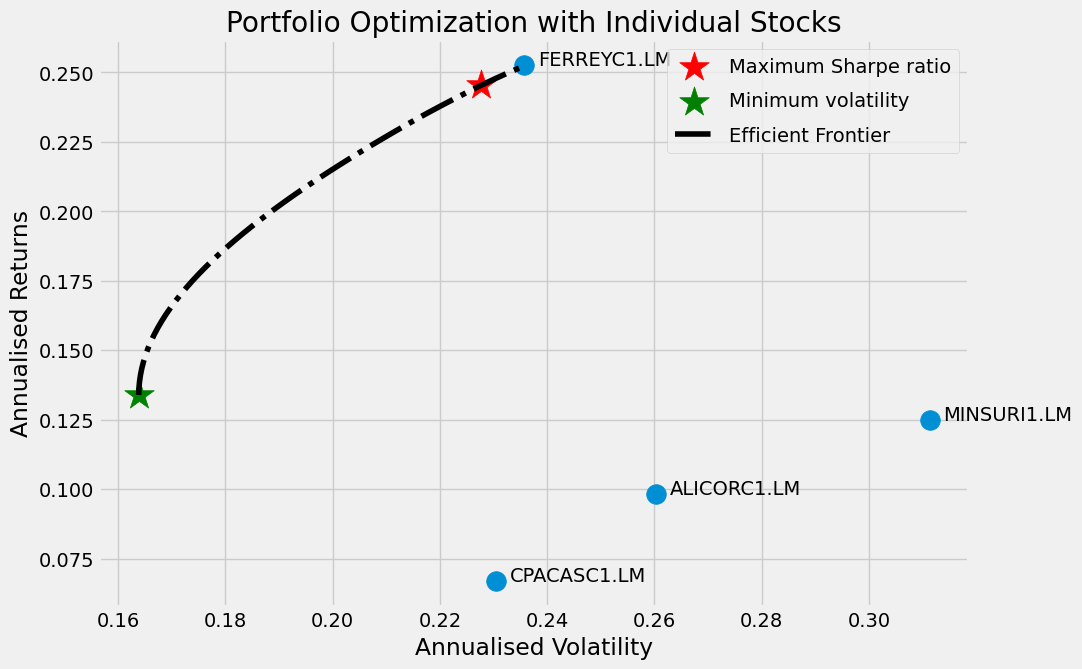

In [38]:
display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate)
